In [1]:
from qiskit import Aer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import SpinMapper, DirectMapper, LinearMapper, JordanWignerMapper
from qiskit.opflow import X, Z, I

import pylab
import numpy as np
import retworkx as rx
from qiskit_nature.problems.second_quantization.lattice import (
    BoundaryCondition,
    IsingModel,
    FermiHubbardModel,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


In [2]:
from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

In [3]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))

In [4]:
from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal

tl_circuit = TwoLocal(
    rotation_blocks=["h", "rx"],
    entanglement_blocks="cz",
    entanglement="full",
    skip_final_rotation_layer = True,
    reps=1,
    parameter_prefix="p",
)

vqe_solver = VQE(
    ansatz=tl_circuit,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),
)

In [5]:
#Globally Coupled
def makeDirectIsing(size):
    result = None
    for i in range(size):
        # X operators
        pauli_x = X if i == 0 else I
        for n in range(1, size):
            pauli_x ^= X if i == n else I
        result = result + pauli_x if result else pauli_x

        #Z operators
        for j in range(i):
            pauli_z = Z if i == 0 or j == 0 else I
            for n in range(1,size):
                pauli_z ^= Z if n == i or n == j else I
            result -= pauli_z
    return result
print(makeDirectIsing(4))

1.0 * XIII
+ 1.0 * IXII
- 1.0 * ZZII
+ 1.0 * IIXI
- 1.0 * ZIZI
- 1.0 * IZZI
+ 1.0 * IIIX
- 1.0 * ZIIZ
- 1.0 * IZIZ
- 1.0 * IIZZ


In [7]:
#Locally Coupled
def convertSpin(ham):
    result = None
    for c, x, z in zip(ham._coeffs, ham.x, ham.z):
        if 1 in x:
            pauli_x = X if x[0] == 1 else I
            for n in range(1, ham.register_length):
                pauli_x ^= X if x[n] == 1 else I
            pauli_x *= c
            result = result + pauli_x if result else pauli_x

        if 1 in z:
            pauli_z = Z if z[0] == 1 else I
            for n in range(1, ham.register_length):
                pauli_z ^= Z if z[n] == 1 else I
            pauli_z *= c
            result = result + pauli_z if result else pauli_z
    return result

def makeLatticeIsing(size):
    lattice = LineLattice(size, boundary_condition=BoundaryCondition.PERIODIC)

    t = -1.0  # the interaction parameter
    v = 1.0  # the onsite potential

    ising = IsingModel.uniform_parameters(
        lattice=lattice,
        uniform_interaction=t, #interaction strength -- "hopping term"
        uniform_onsite_potential=v
    )
    return convertSpin(ising.second_q_ops())
print(type(makeLatticeIsing(2)))
print(makeLatticeIsing(5))
print(type(makeLatticeIsing(5)))

<class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>
-1.0 * ZZIII
- 1.0 * IZZII
- 1.0 * IIZZI
- 1.0 * IIIZZ
+ 1.0 * XIIII
+ 1.0 * IXIII
+ 1.0 * IIXII
+ 1.0 * IIIXI
+ 1.0 * IIIIX
- 1.0 * ZIIIZ
<class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>


In [9]:
#Example of Data
latticeIsing = makeLatticeIsing(3)
print("lattice:\n", latticeIsing)
result = vqe_solver.compute_minimum_eigenvalue(latticeIsing)
print(result)
type(type(result))

lattice:
 -1.0 * ZZI
- 1.0 * IZZ
+ 1.0 * XII
+ 1.0 * IXI
+ 1.0 * IIX
- 1.0 * ZIZ
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 4,
    'eigenstate': array([-0.17369599-0.30794432j, -0.17369599-0.30794432j,
       -0.17369599-0.30794432j,  0.17369599+0.30794432j,
       -0.17369599-0.30794432j,  0.17369599+0.30794432j,
        0.17369599+0.30794432j,  0.17369599+0.30794432j]),
    'eigenvalue': (-4.9e-17+0j),
    'optimal_parameters': {   ParameterVectorElement(p[1]): 4.629594344159054,
                              ParameterVectorElement(p[0]): 3.1504957397664963,
                              ParameterVectorElement(p[2]): -3.611365176291518},
    'optimal_point': array([ 3.15049574,  4.62959434, -3.61136518]),
    'optimal_value': -4.9e-17,
    'optimizer_evals': None,
    'optimizer_time': 0.02532482147216797}


abc.ABCMeta

In [187]:
latticeResults = []
directResults = []

In [220]:
n = 12
for i in range(1, n):
    if len(latticeResults) < i:
        latticeResult = vqe_solver.compute_minimum_eigenvalue(makeLatticeIsing(i))
        latticeResults.append(latticeResult)
    if len(directResults) < i:
        directResult = vqe_solver.compute_minimum_eigenvalue(makeDirectIsing(i))
        directResults.append(directResult)
    print(i, latticeResults[i-1].eigenvalue, directResults[i-1].eigenvalue)

1 (-0.999999999999945+0j) (-0.9999999999930462+0j)
2 (-0.999999951849424+0j) (-0.9999999447732311+0j)
3 (-2.9999998891099975+0j) (-2.999999981242082+0j)
4 (-3.9999998627100144+0j) (-5.999999989325323+0j)
5 (-4.999999843539843+0j) (-9.999999000275986+0j)
6 (-1.9999999682680927+0j) (-14.999999967212533+0j)
7 (-6.999999870231009+0j) (-20.999999594268573+0j)
8 (-3.9999996607346784+0j) (-27.99999997985529+0j)
9 (-4.999999265286784+0j) (-35.99999999940627+0j)
10 (-5.999999956250706+0j) (-44.999999958312785+0j)
11 (-6.999999646319773+0j) (-54.99999976199167+0j)


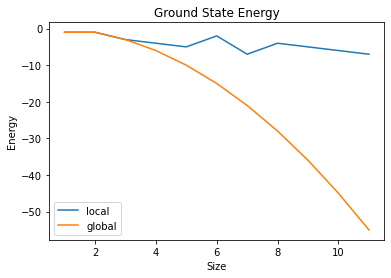

In [221]:
latticeEigenvalues = [r.optimal_value for r in latticeResults]
directEigenvalues = [r.optimal_value for r in directResults]
pylab.plot([*range(1,n)], latticeEigenvalues, label='local')
pylab.plot([*range(1,n)], directEigenvalues, label='global')

pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

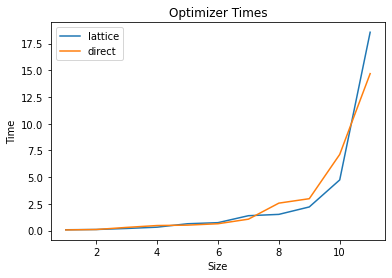

In [222]:
latticeTimes = [r.optimizer_time for r in latticeResults]
directTimes = [r.optimizer_time for r in directResults]
pylab.plot([*range(1,n)], latticeTimes, label='lattice')
pylab.plot([*range(1,n)], directTimes, label='direct')

pylab.xlabel('Size')
pylab.ylabel('Time')
pylab.title('Optimizer Times')
pylab.legend(loc='upper left')